In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import scipy.stats as ss
%matplotlib inline

In [17]:
sales_df = pd.read_csv('data/wish_sales_clean.csv')
sales_df.head()

,price,retail_price,units_sold,uses_ad_boosts,rating,rating_count,badges_count,badge_local_product,badge_product_quality,badge_fast_shipping,...,rating_three_count,rating_two_count,rating_one_count,color_black,color_other,color_white,size_m,size_other,size_s,size_xs
0,16.00,14,100,0,3.76,54,0,0,0,0,...,10.0,1.0,9.0,0,0,1,1,0,0,0
1,8.00,22,20000,1,3.45,6135,0,0,0,0,...,1118.0,644.0,1077.0,0,1,0,0,0,0,1
2,8.00,43,100,0,3.57,14,0,0,0,0,...,2.0,0.0,3.0,0,1,0,0,0,0,1
3,8.00,8,5000,1,4.03,579,0,0,0,0,...,87.0,42.0,36.0,1,0,0,1,0,0,0
4,2.72,3,100,1,3.10,20,0,0,0,0,...,2.0,2.0,6.0,0,1,0,0,0,1,0


## Label: Units Sold

The goal is to predict the number of products will be sold based on the seller and the product information. 

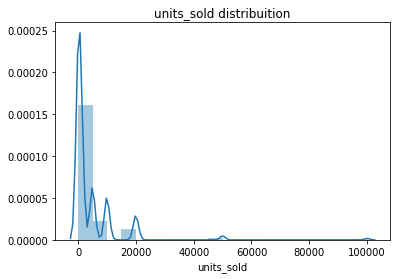

In [148]:
sns.distplot(sales_df["units_sold"], bins=20)
plt.title("units_sold distribuition");

The distribution plot shows that the units_sold data is skewed to the right, and we can apply log transformation on the data to make it less skewed 

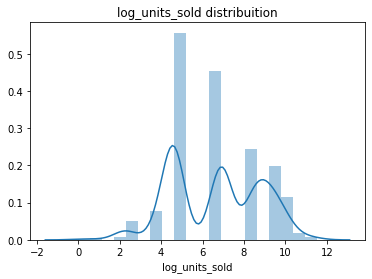

In [18]:
sales_df["log_units_sold"] = np.log(sales_df.units_sold) # apply log transformation on units_sold
sns.distplot(sales_df["log_units_sold"], bins=20)
plt.title("log_units_sold distribuition");

## Numerical Features Exploration

In [19]:
numeric_columns = ['price',
 'retail_price',
 'log_units_sold',
 'units_sold',
 'rating',
 'rating_count',
 'rating_five_count',
 'rating_four_count', 
 'rating_three_count', 
 'rating_two_count',
 'rating_one_count',
 'badges_count',
 'product_variation_inventory',
 'shipping_option_price',
 'inventory_total',
 'merchant_rating_count',
 'merchant_rating',
 'countries_shipped_to']

category_columns = set(sales_df) - set(numeric_columns)
category_columns = list(category_columns)

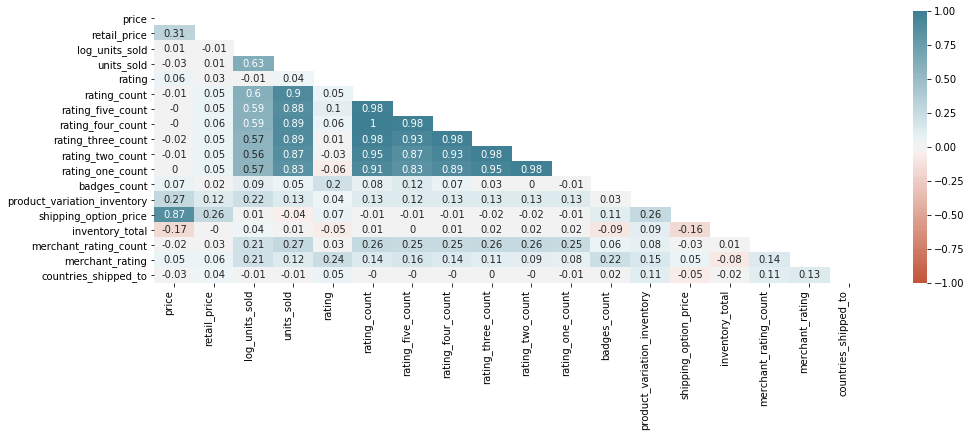

In [151]:
corr = sales_df[numeric_columns].corr().round(2)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize = (16,5))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    mask=mask,
    annot=True,
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);

From the correlation matrix heatmap, we can see that:
- ```rating_count``` and ```rating_{N}_count``` columns have strong postive correlation, and they all highly correlated with the label, ```log_units_sold```. 
- ```price``` and ```shipping_option_price``` are highly correlated. We can drop the ```shipping_option_price``` column
- It is surprised to see that ```merchant_rating``` and ```rating``` do not have strong lineraly relationship with the ```log_units_sold``` consindering that customers usually tend to buy products with high ratings. 
- ```inventory_total```, ```badges_count```, ```countries_shipped_to```, ```price```, and ```retail price``` are not strongly correlated with ```log_units_sold```, but we can draw scatterplots to check if there's any non-linear relationship.



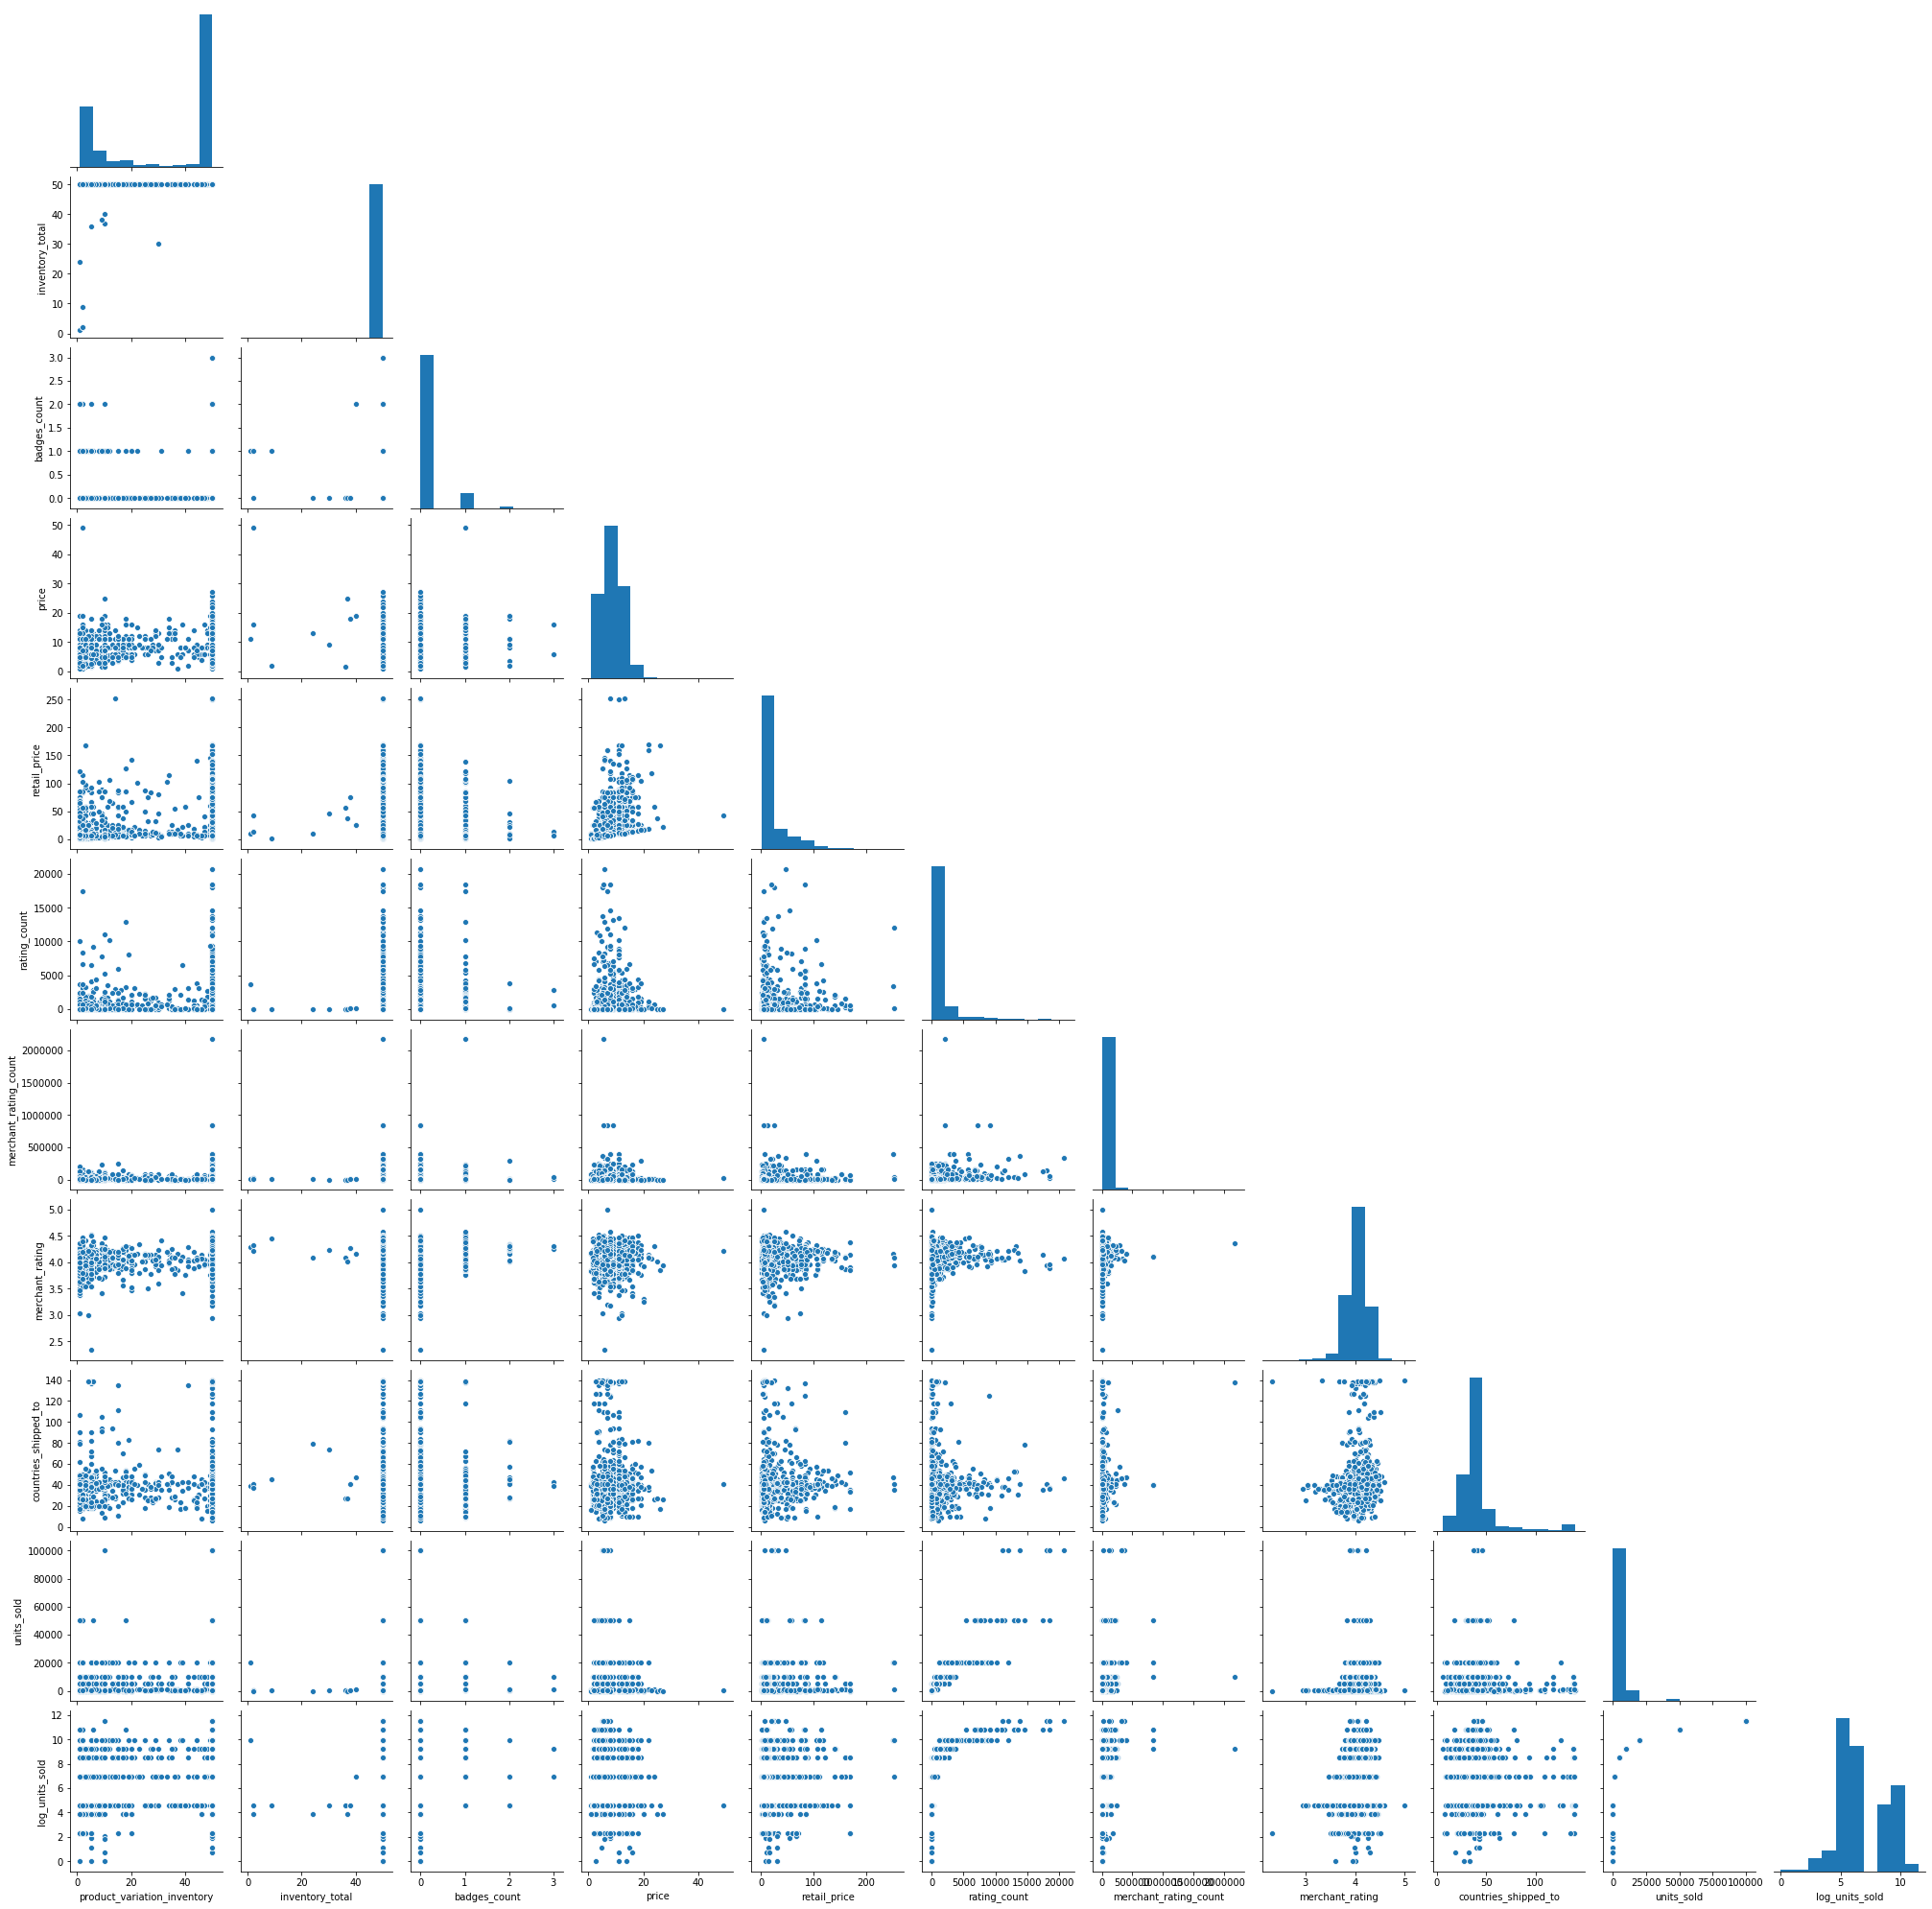

In [152]:
check_col = ["product_variation_inventory",
             "inventory_total", 
             "badges_count", 
             "price", 
             "retail_price", 
             "rating_count",
             "merchant_rating_count",
             "merchant_rating",
             "countries_shipped_to",
             "units_sold",
             "log_units_sold"]
sns.pairplot(sales_df[check_col], corner=True);

- ```inventory_total```: From the histogram, we can see that the majority value of ```inventory_total``` falls on 50, and it does not have much variation. Since it's almost like that the ```inventory_total``` only has a single value(50), we can drop it 
- ```badges_count```: From the histogram, most sellers/products do not have badges. On the other hand, the scatterplot on ```bades_count``` vs ```log_units_sold``` indicates that there are negatively related. 
- ```price```: Cheaper products tend to have more sales
- ```retail_price```: the ```retail_price```'s scatterplot with ```log_units_sold``` is very similiar to the ```price```'s. I'd like to do more exploration on it  
- ```countries_shipped_to```: there's no obvious pattern in the scatterplot between ```countries_shipped_to``` and ```log_units_sold```. A product which can be shipped to more countries does not necessarily mean it has more sales. We can drop this feature

### price and retail_price

Does showing the retail_price influence the cutsomer's buying decision on a product? The intuition is that if a product's price is lower than the retail_price, then a customer is more likey to buy it.

In [153]:
retail_price = sales_df.retail_price
price = sales_df.price

price_diff = (retail_price - price) / retail_price * 100

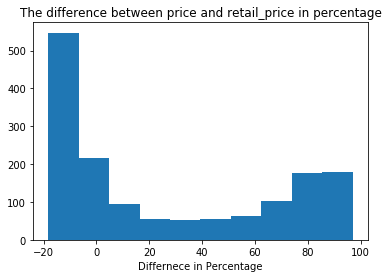

In [154]:
plt.hist(price_diff)
plt.title("The difference between price and retail_price in percentage")
plt.xlabel("Differnece in Percentage");

It's interesting to see that there are many products having price more expensive than the retail price. Now let's compare it with the ```log_units_sold```

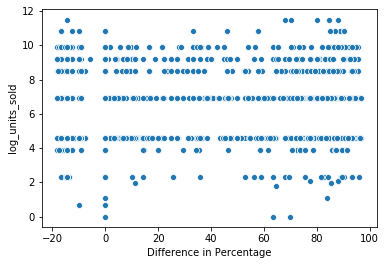

In [155]:
sns.scatterplot(x=price_diff, y=sales_df.log_units_sold)
plt.xlabel("Difference in Percentage");

There's no pattern in the scatterplot. The retail_price feature may not have strong influence on customer's purchase decision. We can drop it

That's the end of our exploration on the numerical features. During the exploration, we decided to drop two columns: ```retail_price```, ```shipping_option_price```, ```countries_shipped_to``` and ```inventory_total```

In [20]:
sales_df.drop(["retail_price","inventory_total", "countries_shipped_to", "shipping_option_price"], axis=1, inplace=True)
sales_df.columns

Index(['price', 'units_sold', 'uses_ad_boosts', 'rating', 'rating_count',
       'badges_count', 'badge_local_product', 'badge_product_quality',
       'badge_fast_shipping', 'tags', 'product_variation_inventory',
       'shipping_option_name', 'shipping_is_express', 'origin_china',
       'merchant_rating_count', 'merchant_rating',
       'merchant_has_profile_picture', 'limited_quantity', 'discount',
       'no_urgency', 'rating_five_count', 'rating_four_count',
       'rating_three_count', 'rating_two_count', 'rating_one_count',
       'color_black', 'color_other', 'color_white', 'size_m', 'size_other',
       'size_s', 'size_xs', 'log_units_sold'],
      dtype='object')

## Categorical Features Exploration

In [21]:
category_columns

['uses_ad_boosts',
 'size_other',
 'badge_fast_shipping',
 'tags',
 'no_urgency',
 'limited_quantity',
 'shipping_is_express',
 'size_s',
 'shipping_option_name',
 'badge_local_product',
 'size_m',
 'merchant_has_profile_picture',
 'origin_china',
 'color_white',
 'color_other',
 'size_xs',
 'color_black',
 'discount',
 'badge_product_quality']

### shipping-related categorical features: 
- ```shipping_option_name``` 
- ```badge_fast_shipping```: Badge awarded when this product's order is consistently shipped rapidly
- ```shipping_is_express```: whether the shipping is express or not

In [158]:
Counter(sales_df.shipping_option_name.str.lower()).most_common()

[('livraison standard', 1474),
 ('standard shipping', 21),
 ('envio padrão', 9),
 ('expediere standard', 6),
 ('envío normal', 5),
 ('الشحن القياسي', 4),
 ('standardversand', 3),
 ('standardowa wysyłka', 3),
 ('livraison express', 3),
 ('стандартная доставка', 3),
 ('standart gönderi', 2),
 ('การส่งสินค้ามาตรฐาน', 2),
 ('spedizione standard', 2),
 ('ការដឹកជញ្ជូនតាមស្តង់ដារ', 1),
 ('ekspresowa wysyłka', 1)]

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3585 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3634 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3619 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3626 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3656 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ec2-user/

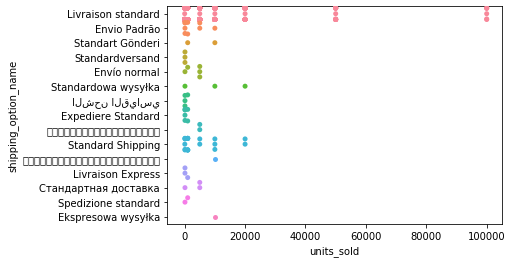

In [159]:
sns.swarmplot(x="units_sold", y="shipping_option_name",data=sales_df);

Since livraison standard shipping occupies the majority of shipping options, we can convert the ```shipping_option_name``` to a binary columns: whether it's livraison standard(1) or not (0)

In [22]:
sales_df_ship = sales_df.copy() 
sales_df_ship.loc[sales_df.shipping_option_name.str.lower() == "livraison standard", 
             "shipping_option_name"] = 1
sales_df_ship.loc[sales_df.shipping_option_name.str.lower() != "livraison standard", 
             "shipping_option_name"] = 0

sales_df_ship.rename(columns={"shipping_option_name": "shipped_by_livraison_standard"}, inplace=True)

In [161]:
Counter(sales_df_ship.shipped_by_livraison_standard)

Counter({1: 1474, 0: 65})

### Tags

```tags``` is the tags set by the seller. This column is interesting since there are multiple tags in it

In [23]:
category_count = pd.read_csv('data/unique-categories-sorted-by-count.csv')
category_count.head()

,count,keyword
0,1321,Summer
1,1315,Women's Fashion
2,1082,Fashion
3,961,Women
4,905,Casual


In [24]:
num_category = category_count.shape[0]
print("there are {} unique categories".format(num_category))

there are 2620 unique categories


In [25]:
for n in [10, 20, 40, 60, 100]:
    top_n_category = sum(category_count.iloc[:n,0])
    percent = format(100 * top_n_category / sum(category_count["count"]), '0.3f')
    print("The top {} tags are {}% of the total tags".format(n, percent))

The top 10 tags are 30.693% of the total tags
The top 20 tags are 41.002% of the total tags
The top 40 tags are 54.363% of the total tags
The top 60 tags are 61.645% of the total tags
The top 100 tags are 69.245% of the total tags


Convert the tags column into categorical columns by comparing the top 20 category keyword with the tags in our Wish sales dataset. If a product has the tag which is in the top 20 keyword, return an "Yes" (1), else return "No" (0)

In [26]:
top_20_key = category_count.iloc[:20,1].str.lower().tolist() #slice the top40 keyword and convert to lower case
sales_tag = sales_df_ship.copy()

for k in top_20_key:
    sales_tag["tag_"+k] = sales_tag.tags.str.lower().str.contains(k).astype(int)
sales_new_tags = sales_tag.drop("tags", axis=1)

In [27]:
sales_new_tags.columns

Index(['price', 'units_sold', 'uses_ad_boosts', 'rating', 'rating_count',
       'badges_count', 'badge_local_product', 'badge_product_quality',
       'badge_fast_shipping', 'product_variation_inventory',
       'shipped_by_livraison_standard', 'shipping_is_express', 'origin_china',
       'merchant_rating_count', 'merchant_rating',
       'merchant_has_profile_picture', 'limited_quantity', 'discount',
       'no_urgency', 'rating_five_count', 'rating_four_count',
       'rating_three_count', 'rating_two_count', 'rating_one_count',
       'color_black', 'color_other', 'color_white', 'size_m', 'size_other',
       'size_s', 'size_xs', 'log_units_sold', 'tag_summer',
       'tag_women's fashion', 'tag_fashion', 'tag_women', 'tag_casual',
       'tag_plus size', 'tag_sleeveless', 'tag_dress', 'tag_shorts',
       'tag_tops', 'tag_sexy', 'tag_beach', 'tag_sleeve', 'tag_short sleeves',
       'tag_print', 'tag_shirt', 'tag_tank', 'tag_necks', 'tag_v-neck',
       'tag_printed'],
      dtyp

Just take a took, we found that there are some tags which have very similiar meaning, such as "women", "fashion", and "women's fashion". We can check the association between them by calculating the Cramer's V. If Cramer's V shows that they have strong association, we could drop one of them to reduce our feature space size.

In [28]:
category_columns2 = category_columns.copy()
category_columns2.extend([ 'shipped_by_livraison_standard','tag_summer', 'tag_women\'s fashion', 'tag_fashion',
       'tag_women', 'tag_casual', 'tag_plus size', 'tag_sleeveless',
       'tag_dress', 'tag_shorts', 'tag_tops', 'tag_sexy', 'tag_beach',
       'tag_sleeve', 'tag_short sleeves', 'tag_print', 'tag_shirt', 'tag_tank',
       'tag_necks', 'tag_v-neck', 'tag_printed'])
          
category_columns2.remove('shipping_option_name')
category_columns2.remove('tags')
category_columns2

['uses_ad_boosts',
 'size_other',
 'badge_fast_shipping',
 'no_urgency',
 'limited_quantity',
 'shipping_is_express',
 'size_s',
 'badge_local_product',
 'size_m',
 'merchant_has_profile_picture',
 'origin_china',
 'color_white',
 'color_other',
 'size_xs',
 'color_black',
 'discount',
 'badge_product_quality',
 'shipped_by_livraison_standard',
 'tag_summer',
 "tag_women's fashion",
 'tag_fashion',
 'tag_women',
 'tag_casual',
 'tag_plus size',
 'tag_sleeveless',
 'tag_dress',
 'tag_shorts',
 'tag_tops',
 'tag_sexy',
 'tag_beach',
 'tag_sleeve',
 'tag_short sleeves',
 'tag_print',
 'tag_shirt',
 'tag_tank',
 'tag_necks',
 'tag_v-neck',
 'tag_printed']

Notice that all the catergoical features have been transformed to binary 

In [168]:
# A function to calculate Cramer's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [169]:
rows = []

#calculate Cramer's V for categtorical features 
for cat1 in category_columns2:
    col = []
    for cat2 in category_columns2:
        cramers = cramers_v(sales_new_tags[cat1], sales_new_tags[cat2])
        col.append(round(cramers,2))
    rows.append(col)

carmers_val = np.array(rows)
carmers_df= pd.DataFrame(carmers_val, columns = category_columns2, 
                        index= category_columns2)

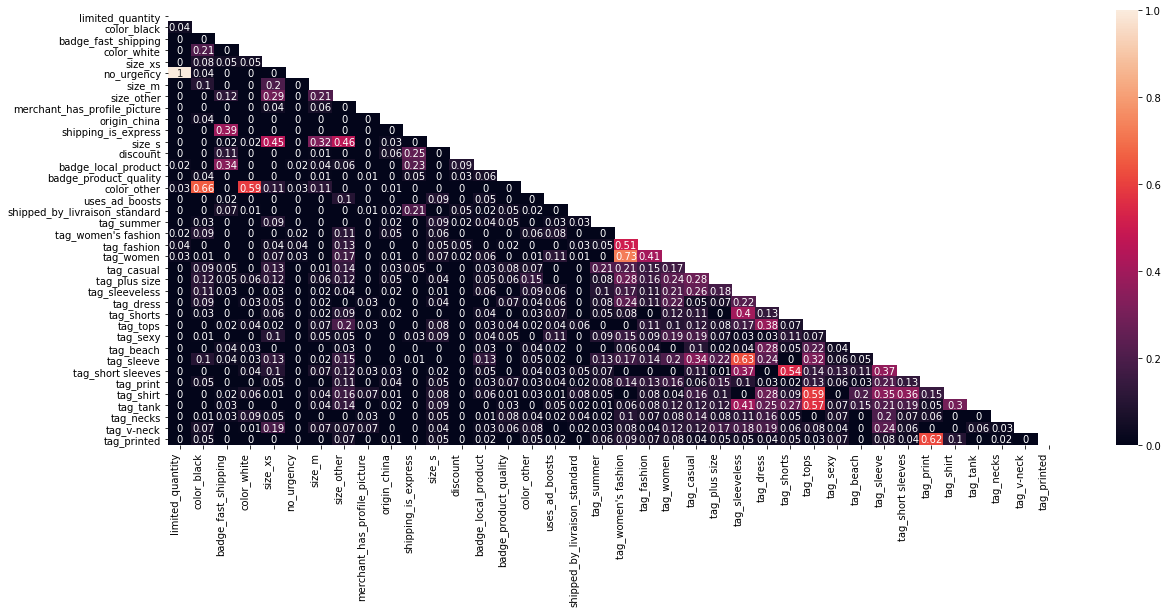

In [170]:
mask = np.zeros_like(carmers_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize = (20,8))
ax = sns.heatmap(
    carmers_df, 
    vmin=0, vmax=1,
    mask=mask,
    annot=True,
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);

Features which have strong association (Cramer's V~>0.6): 

- ```no_urgency``` and ```limited_quantity```(1)
- ```color_other``` and ```color_black``` (0.66)
- ```color_other``` and ```color_white``` (0.59)
- ```tag_women's_fashion``` and ```tag_women``` (0.73)
- ```tag_sleeveless``` and ```tag_sleeve``` (0.63)
- ```tag_tops``` and ```top_shirt``` (0.59)
- ```tag_tops``` and ```top_tank``` (0.57)
- ```tag_print``` and ```tag_printed``` (0.62)

In [29]:
#drop no_urgency, color_other, tag_women, tag_sleeveless, tag_tops, tag_printed
drop_col = ["no_urgency","color_other", "tag_women", "tag_sleeveless", "tag_tops", "tag_printed"]
sales_filter_cat = sales_new_tags.drop(drop_col, axis=1)
            
for col in drop_col:
    category_columns2.remove(col)

Since all the categorical features are binary variable, we can get the correlation between them and the units_sold via calculating Point Biserial Correlation

In [30]:
corr=[]
for col in category_columns2:
    r, p = ss.pointbiserialr(list(map(int,sales_filter_cat[col])), sales_filter_cat["log_units_sold"])
    corr.append(r)

pb_df = pd.DataFrame(corr, index = category_columns2, columns = ["correlation"])

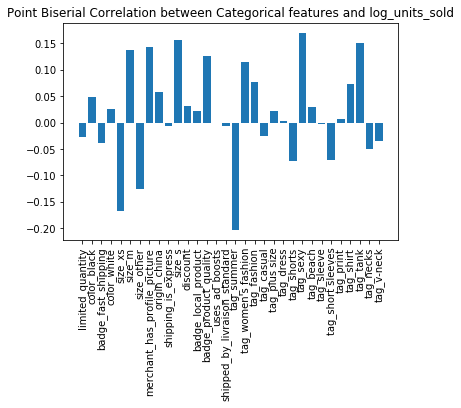

In [173]:
plt.bar(pb_df.index, height=pb_df.correlation)
plt.xticks(rotation=90)
plt.title("Point Biserial Correlation between Categorical features and log_units_sold");

In [31]:
sales_drop_cat = sales_filter_cat.drop(pb_df[abs(pb_df.correlation) < 0.1 ].index.tolist(), axis=1)

### Save the result dataset to local

In [32]:
sales_drop_cat.to_csv('data/wish_sales_explore.csv',index=False)